In [14]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from shutil import copyfile
#import zipfile
import random
import pickle

plt.ion()   # interactive mode

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading in the data 
The dataset is already split into training and validation subfolders: 


*   /train contains all images from the Leeds Butterfly set, in per-class named subfolders, except for 10 images each held back for the validation set.
*   /val contains 10 images from each 10 classes in per-class named subfolders.




In [16]:
# loading in data from set in Drive
datapath = '/content/drive/MyDrive/Colab Datasets/Insect/SplitLeedsButterflyDataset'
print(os.listdir(datapath))

print(os.listdir("{}/train".format(datapath)))



['Readme.txt', 'val', 'train']
['010_Vanessa Cardui', '006_Nymphalis Antiopa', '002_Heliconius Charitonius', '009_Vanessa Atalanta', '004_Junonia Coenia', '007_Papilio Cresphontes', '005_Lycaena Phlaeas', '008_Pieris Rapae', '003_Heliconius Erato', '001_Danaus Plexippus']


In [13]:
training_path = "{}/train".format(datapath)
validation_path = "{}/val".format(datapath)
# Count files in subdirectories

def file_count(path):
   return sum(len(files) for _, _, files in os.walk(path))

print("training set:", len(os.listdir(training_path))," classes, ", file_count(training_path), " files in subfolders")
print("validation set:", len(os.listdir(validation_path)), " classes, ", file_count(validation_path), " files in subfolders")


training set: 10  classes,  732  files in subfolders
validation set: 10  classes,  100  files in subfolders


In [73]:
# Showing some pictures
from PIL import Image

images = []
for folder in os.listdir(training_path):
  for image in os.listdir(training_path + '/' + folder):
    images.append(os.path.join(training_path, folder, image))

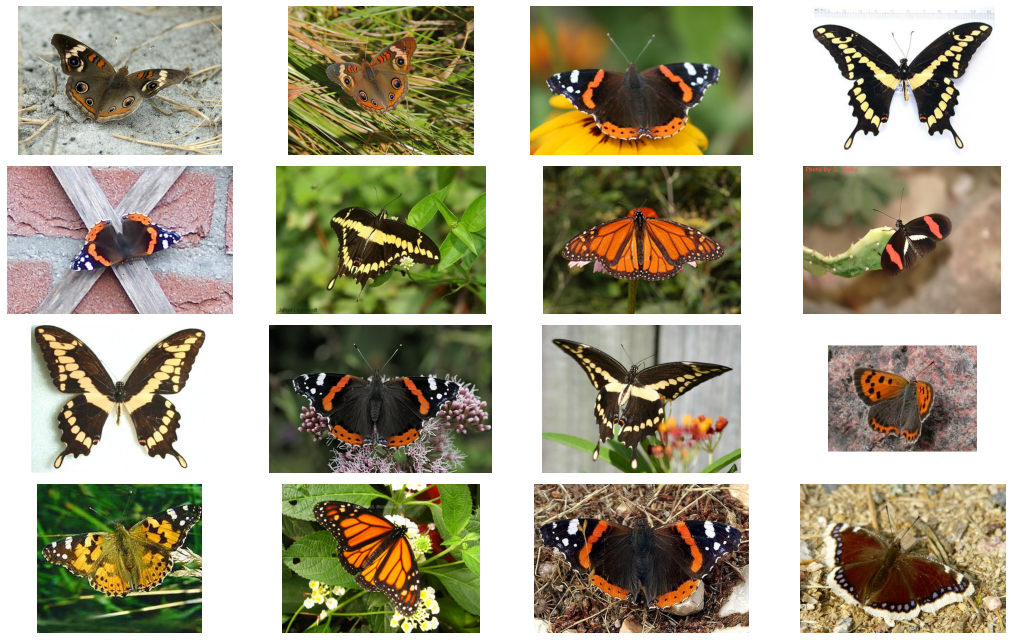

In [75]:

plt.figure(1, figsize=(15,9))

n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = Image.open(random_img)
  plt.subplot(4,4, n)
  plt.axis('off')
  plt.imshow(imgs)

plt.tight_layout()
plt.show()


Transforms:
1. Preprocessing:
In order to use our images with a network pretrained on the ImageNet dataset, we need to preprocess our images in the same way as the in the pretrained network. For that, we need to rescale the images to 224×224 and normalize them as per ImageNet standards. We can use the torchvision transforms:


In [64]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = datapath
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print class names & set sizes
print(class_names)
print(dataset_sizes)
print(type(dataloaders['train']))

['001_Danaus Plexippus', '002_Heliconius Charitonius', '003_Heliconius Erato', '004_Junonia Coenia', '005_Lycaena Phlaeas', '006_Nymphalis Antiopa', '007_Papilio Cresphontes', '008_Pieris Rapae', '009_Vanessa Atalanta', '010_Vanessa Cardui']
{'train': 732, 'val': 100}
<class 'torch.utils.data.dataloader.DataLoader'>


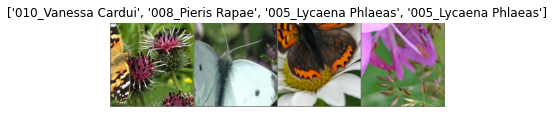

In [65]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [76]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [85]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # how to set actual result in the title too?
                #ax.set_title('predicted: {}'.format(class_names[preds[j]]), 'correct: {}'.format((labels[j] == class_names[preds[j]])))
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [78]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [79]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 1.0571 Acc: 0.6762
val Loss: 0.0257 Acc: 1.0000

Epoch 1/9
----------
train Loss: 0.4443 Acc: 0.8784
val Loss: 0.0068 Acc: 1.0000

Epoch 2/9
----------
train Loss: 0.3862 Acc: 0.8880
val Loss: 0.0347 Acc: 0.9900

Epoch 3/9
----------
train Loss: 0.3451 Acc: 0.8907
val Loss: 0.0077 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.2618 Acc: 0.9262
val Loss: 0.0430 Acc: 0.9900

Epoch 5/9
----------
train Loss: 0.2169 Acc: 0.9413
val Loss: 0.0121 Acc: 1.0000

Epoch 6/9
----------
train Loss: 0.2912 Acc: 0.9180
val Loss: 0.0104 Acc: 1.0000

Epoch 7/9
----------
train Loss: 0.2367 Acc: 0.9385
val Loss: 0.0063 Acc: 1.0000

Epoch 8/9
----------
train Loss: 0.1855 Acc: 0.9508
val Loss: 0.0088 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.2130 Acc: 0.9426
val Loss: 0.0106 Acc: 1.0000

Training complete in 4m 54s
Best val Acc: 1.000000


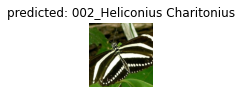

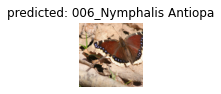

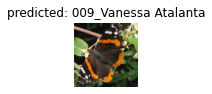

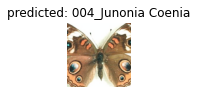

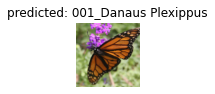

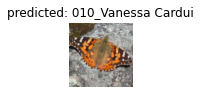

In [86]:
visualize_model(model_ft)

In [ ]:
torch.save(model_ft.state_dict(), '/tmp/model_state.pth')
# /content/drive/MyDrive/database

In [ ]:
pickle.dump(class_names, open("/tmp/class_names.pkl", "wb"), pickle.HIGHEST_PROTOCOL)